In [1]:
import glob
import librosa
import re
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.signal import resample
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from scipy import linalg as la

/Users/Seong-EunCho/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Load data

In [2]:
train_loc = "TIMIT/TRAIN/*"
train_data = []
audios = []
rate = 16000
mel_ = librosa.filters.mel(rate, 2048, n_mels=80)
N = len(glob.glob(train_loc))
for i, f_1 in enumerate(glob.glob(train_loc)):
    print(str(i+1) + "/" + str(N))
    loop = tqdm(total=len(glob.glob(f_1 + '/*')), position=0, leave=False)
    for f_2 in glob.glob(f_1 + '/*'):
        wav_files = glob.glob(f_2 + '/*.WAV')
        for wav_file in wav_files:
            f_name = wav_file.split('/')[-1].split('.')[0]
            phn_file = f_2 + '/' + f_name + '.PHN'
            phones = open(phn_file, 'r').read()
            signal, rate = librosa.load(wav_file, sr=None)
            audio = signal
            for line in phones.split('\n'):
                segment = line.split()
                if len(segment) == 3:
                    start = int(segment[0])
                    end = int(segment[1])
                    phoneme = segment[2]
                    sample = signal[start:end]
                    spectrum = np.log(np.abs(sp.fft(sample))[:len(sample)//2])
                    spectrum = resample(spectrum, 1025)
                    mel = np.dot(mel_, spectrum)
                    train_data.append((mel, phoneme))
        loop.update(1)
    loop.close()
    break

  0%|          | 0/38 [00:00<?, ?it/s]

1/8


  3%|▎         | 1/38 [00:00<00:07,  4.81it/s]/Users/Seong-EunCho/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
/Users/Seong-EunCho/anaconda/lib/python3.6/site-packages/scipy/signal/signaltools.py:2264: RuntimeWarning: invalid value encountered in multiply
  y = fftpack.ifft(Y, axis=axis) * (float(num) / float(Nx))


In [3]:
df = pd.DataFrame(train_data)
data = pd.DataFrame(np.vstack(df[0]))
data["phoneme"] = df[1]
data = data.dropna()
data.phoneme = data.phoneme#.astype('category')
X = data.drop(columns=["phoneme"]).values
y = data.phoneme.values#.codes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X.shape

(14397, 80)

# Random Forest

In [120]:
rf = RandomForestClassifier(n_estimators=200, max_depth=30, random_state=42)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.36203703703703705

# XGBoost

In [56]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
params = {"max_depth": 20, 
          "eta": 0.3, 
          "num_class": 61, 
          "gamma": 1, 
          "lambda": 10, 
          "alpha": 10}
params["objective"] = "multi:softmax"
params["eval_metric"] = "merror"
params['nthread'] = 4
evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [60]:
num_round = 30
bst = xgb.train(params, dtrain, num_round, evallist)

[10:02:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 50 pruned nodes, max_depth=20
[10:02:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 92 pruned nodes, max_depth=20
[10:02:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 128 pruned nodes, max_depth=20
[10:02:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 56 pruned nodes, max_depth=20
[10:02:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 78 pruned nodes, max_depth=15
[10:02:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 138 pruned nodes, max_depth=20
[10:02:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 70 pruned nodes, max_depth=11
[10:02:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 110 pruned nodes, max_depth=20
[10:02:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra n

In [61]:
y_pred = bst.predict(dtest)

In [62]:
score = sum(y_pred == y_test) / len(y_test)
score

0.3975715361445783

# PCA

In [4]:
class PCA:
    def __init__(self, X, y=None, s=None, sparse=False, center=True):
        self.X = X - X.mean(axis=0) if center else X
        self.y = y
        self.sparse = sparse
        if s == None:
            n, d = X.shape
            s = d
        if not self.sparse:
            U, sig, Vh = la.svd(self.X, full_matrices=False)
            self.sig = sig[:s]**2
            self.Vh = Vh[:s]
        else:
            _, sig, Vh = spla.svds(self.X, k=s, return_singular_vectors="vh")
            self.sig = sig**2
            self.Vh = Vh
        self.a = self.transform(self.X)
        self.proj_X = self.project(self.X)
        if type(self.y) != None:
            self.y_dict = {}
            A = np.vstack([self.a, self.y])
            for yj in np.unique(self.y):
                curr_a = A.T[A[s] == yj][:, :s]
                if len(curr_a) != 0:
                    self.y_dict[yj] = curr_a.mean(axis=0)
    
    def update_s(self, s):
        if not self.sparse:
            U, sig, Vh = la.svd(self.X, full_matrices=False)
            self.sig = sig[:s]**2
            self.Vh = Vh[:s]
        else:
            _, sig, Vh = spla.svds(self.X, k=s, return_singular_vectors="vh")
            self.sig = sig**2
            self.Vh = Vh
        self.a = self.transform(self.X)
        self.proj_X = self.project(self.X)
        if type(self.y) != None:
            A = np.vstack([self.a, self.y])
            for yj in np.unique(self.y):
                curr_a = A.T[A[s] == yj][:, :s]
                if len(curr_a) != 0:
                    self.y_dict[yj] = curr_a.mean(axis=0)
    
    def transform(self, x):
        return self.Vh@x.T
    
    def project(self, x):
        return self.Vh.T@self.a
    
    def predict(self, x):
        a_test = self.Vh @ x.T
        predicted = []
        for a in a_test.T:
            similarities = []
            for key, value in self.y_dict.items():
                similarity = np.dot(a, value) / (la.norm(a)*la.norm(value))
                similarities.append((similarity, key))
            predicted.append(max(similarities, key=lambda x: x[0])[1])
        return predicted

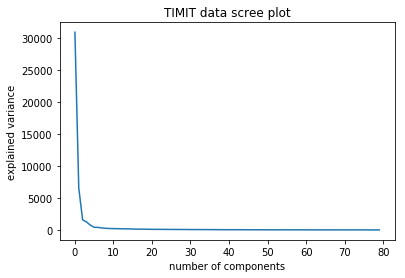

[6.70157116e-01 1.41852061e-01 3.42474728e-02 2.72741109e-02
 1.61096607e-02 8.96661562e-03 8.64242819e-03 6.68000497e-03
 5.44874704e-03 4.87620321e-03 4.56986842e-03 4.21412790e-03
 4.02060844e-03 3.77649078e-03 3.61424121e-03 3.04501979e-03
 2.77207427e-03 2.56893427e-03 2.53531917e-03 2.22754202e-03
 2.09125942e-03 2.04008080e-03 2.01768107e-03 1.86994495e-03
 1.79677810e-03 1.71104896e-03 1.63685047e-03 1.53461543e-03
 1.51134944e-03 1.42023804e-03 1.37337066e-03 1.26640536e-03
 1.21360367e-03 1.19346096e-03 1.15369058e-03 1.09558271e-03
 1.00106945e-03 9.34463915e-04 8.53510212e-04 8.40784354e-04
 7.78693965e-04 7.56365748e-04 7.48371641e-04 7.28482287e-04
 6.71369417e-04 6.08365519e-04 5.83489226e-04 5.45465672e-04
 4.98372162e-04 4.87536544e-04 4.79723095e-04 4.52988407e-04
 4.30072208e-04 4.03303919e-04 3.73399545e-04 3.55232553e-04
 3.49504250e-04 3.33086415e-04 3.15500839e-04 2.95692022e-04
 2.83640942e-04 2.67532454e-04 2.62141964e-04 2.51151995e-04
 2.38275422e-04 2.265888

In [110]:
pca_timit = PCA(X, y=y)
n, d = X.shape
fig = plt.figure()
plt.plot(np.arange(d), pca_timit.sig)
plt.xlabel("number of components")
plt.ylabel("explained variance")
plt.title("TIMIT data scree plot")
plt.show()
print(pca_timit.sig / pca_timit.sig.sum())
i = 1
p = 0
while p < .9:
    p = np.sum(pca_timit.sig[:i]) / np.sum(pca_timit.sig)
    print(i, p)
    i+=1

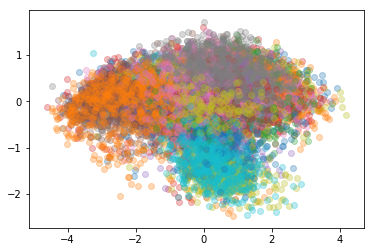

In [111]:
pca_timit.update_s(2)
A = np.vstack([pca_timit.a, pca_timit.y])
for i in np.unique(y):
    curr_a = A.T[A[2] == i][:, :2]
    plt.scatter(curr_a[:, 0], curr_a[:, 1], alpha=0.3)
plt.show()

In [17]:
pca_train = PCA(X_train, y=y_train, s=20, center=False)
y_pred = pca_train.predict(X_test)

In [18]:
sum(y_pred == y_test) / len(y_test)

0.22060185185185185